# Algebraic and AI-Assisted Anomaly Detection for Robotic Sensor Data

## Robust PCA and Manifold Reconstruction Error

- Load normalized data
- Apply RPCA (low rank + sparse decomposition)
- Apply Manifold Reconstruction Error using Isomap
- Compare results + export anomaly scores

[INFO] Normalized datasets found:
 - lp1_norm.csv
 - lp2_norm.csv
 - lp3_norm.csv
 - lp4_norm.csv
 - lp5_norm.csv
[INFO] Datasets loaded: ['lp1', 'lp2', 'lp3', 'lp4', 'lp5']

=== Dataset: lp1 ===
[INFO] Using 1320 samples x 6 features
[INFO] Running Robust PCA...
[INFO] Converged after 614 iterations.


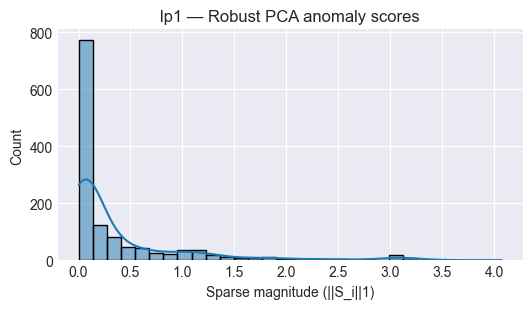

[INFO] Running Isomap reconstruction...
[INFO] Manifold Recon Error obtained


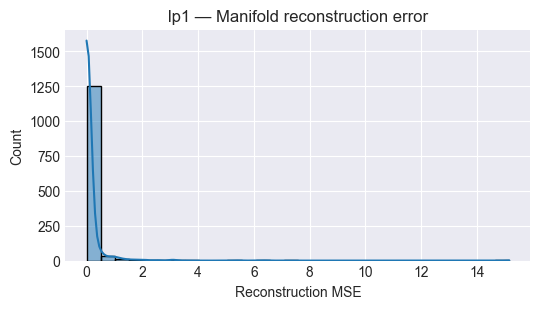

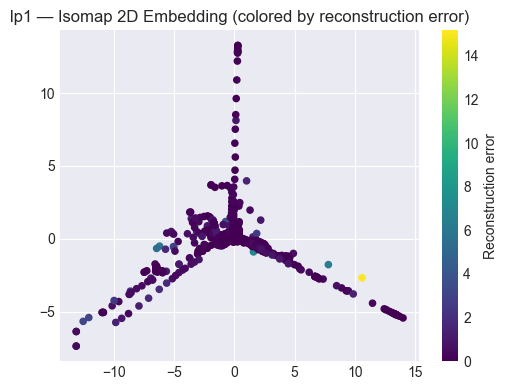

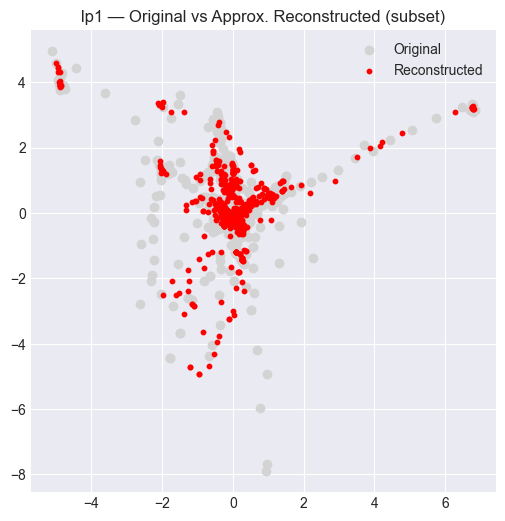


=== Dataset: lp2 ===
[INFO] Using 705 samples x 6 features
[INFO] Running Robust PCA...
[INFO] Converged after 731 iterations.


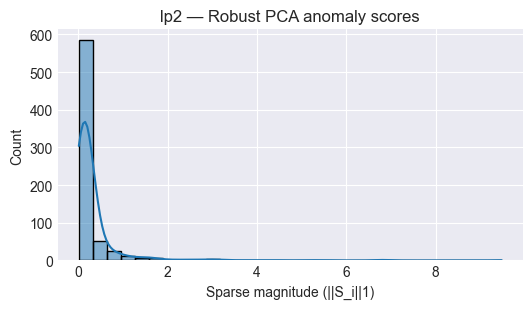

[INFO] Running Isomap reconstruction...
[INFO] Manifold Recon Error obtained


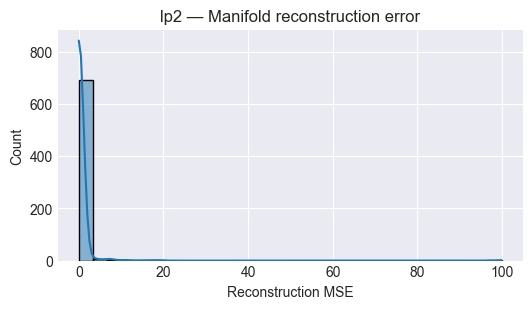

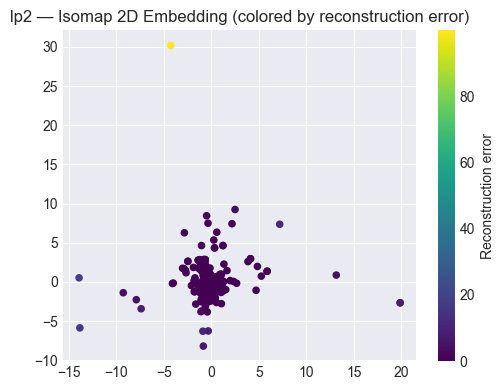

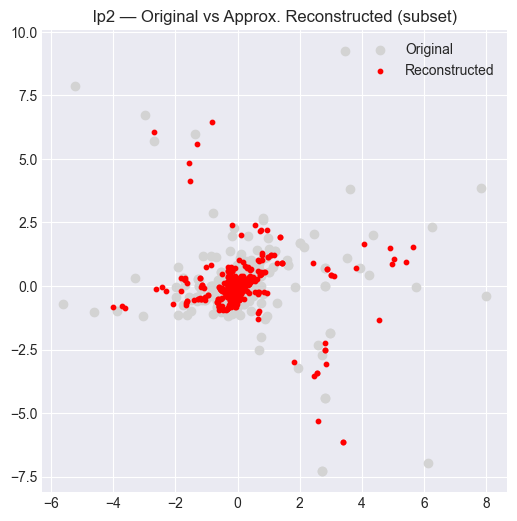


=== Dataset: lp3 ===
[INFO] Using 705 samples x 6 features
[INFO] Running Robust PCA...
[INFO] Converged after 731 iterations.


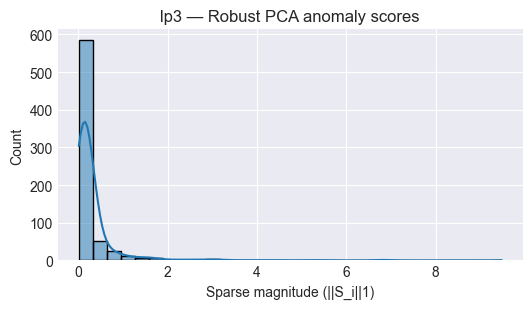

[INFO] Running Isomap reconstruction...
[INFO] Manifold Recon Error obtained


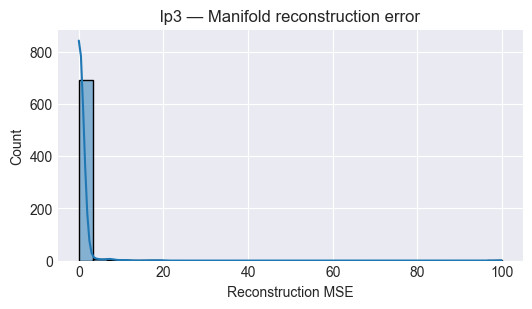

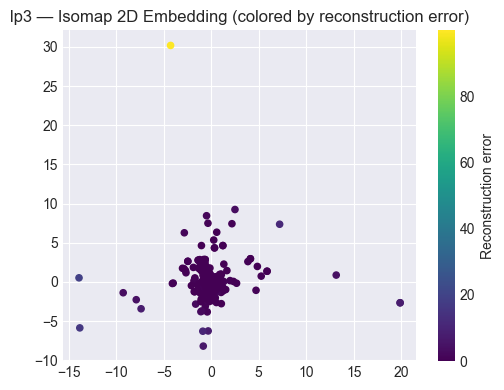

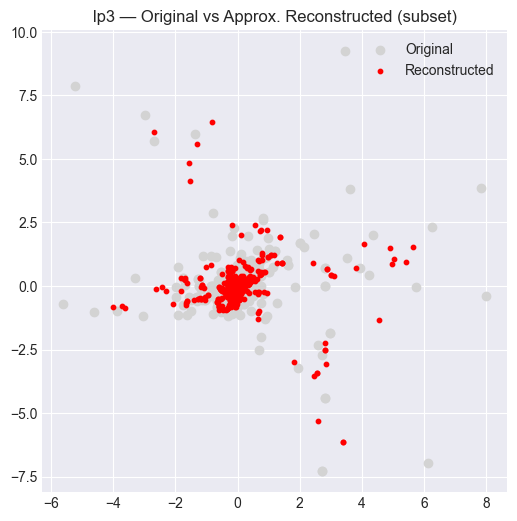


=== Dataset: lp4 ===
[INFO] Using 1755 samples x 6 features
[INFO] Running Robust PCA...
[INFO] Converged after 692 iterations.


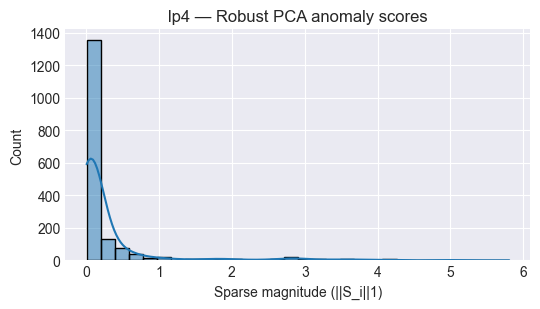

[INFO] Running Isomap reconstruction...
[INFO] Manifold Recon Error obtained


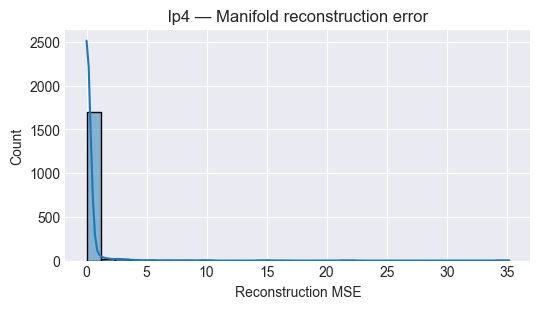

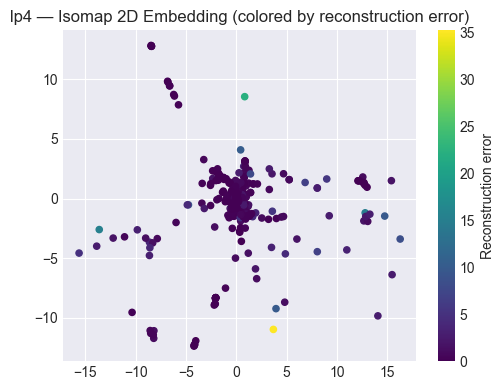

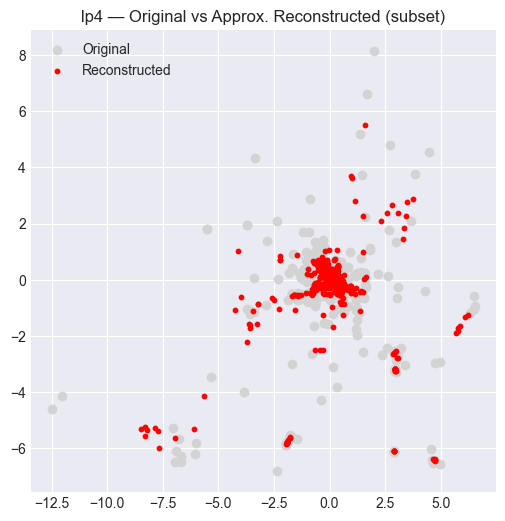


=== Dataset: lp5 ===
[INFO] Using 2460 samples x 6 features
[INFO] Running Robust PCA...
[INFO] Converged after 902 iterations.


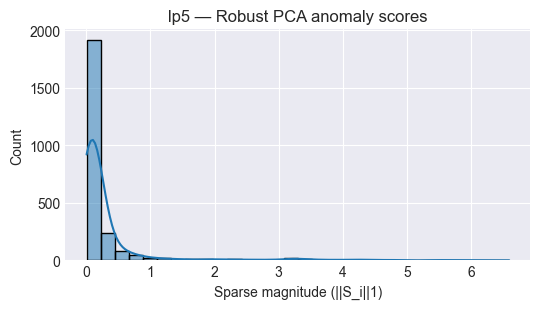

[INFO] Running Isomap reconstruction...
[INFO] Manifold Recon Error obtained


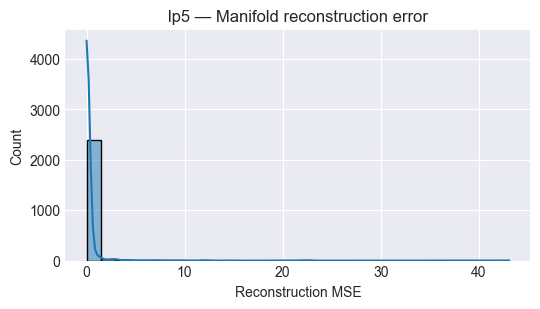

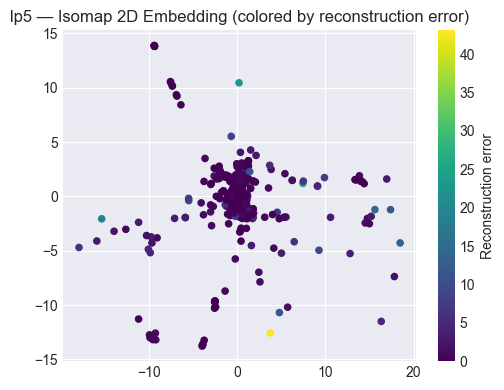

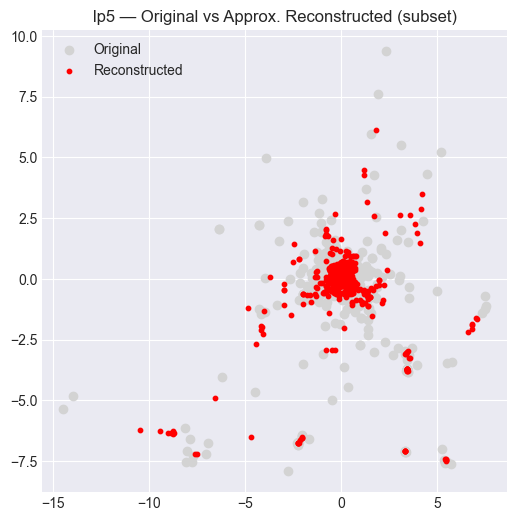

,Dataset,RobustPCA_mean,RobustPCA_std,Manifold_mean,Manifold_std
0,lp1,0.407280,0.697117,0.122445,0.625301
1,lp2,0.320076,0.719515,0.401404,3.970949
2,lp3,0.320076,0.719515,0.401404,3.970949
3,lp4,0.312305,0.756307,0.206370,1.338333
4,lp5,0.317627,0.756974,0.204965,1.421414


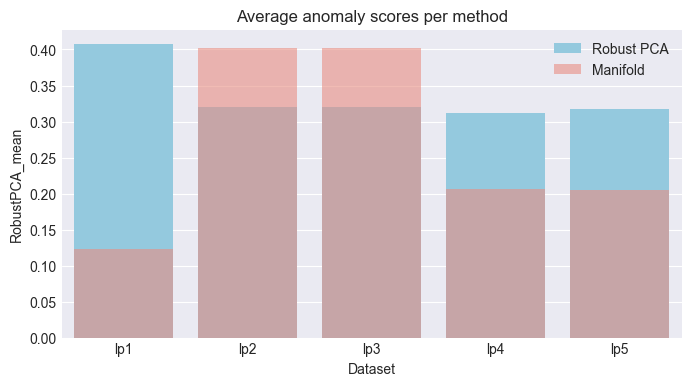

[INFO] Saved → ../results/lp1_robustpca_manifold.csv
[INFO] Saved → ../results/lp2_robustpca_manifold.csv
[INFO] Saved → ../results/lp3_robustpca_manifold.csv
[INFO] Saved → ../results/lp4_robustpca_manifold.csv
[INFO] Saved → ../results/lp5_robustpca_manifold.csv

Robust PCA and Manifold-based anomaly detection completed.


In [8]:
# --- 1. Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import svds
from numpy.linalg import norm

SEED = 42
np.random.seed(SEED)
plt.style.use("seaborn-v0_8-darkgrid")
pd.set_option("display.max_columns", None)


# --- 2. Paths ---
data_path = Path("../data/normalized")
files = sorted(data_path.glob("*.csv"))
results_path = Path("../results")
results_path.mkdir(exist_ok=True)

print("[INFO] Normalized datasets found:")
for f in files:
    print(f" - {f.name}")

# --- 3. Load datasets ---
datasets = {f.stem.replace("_norm", ""): pd.read_csv(f) for f in files}
print(f"[INFO] Datasets loaded: {list(datasets.keys())}")


"""Part 1 -> Robust PCA"""

def robust_pca(X, lam=None, mu=None, max_iter=1000, tol=1e-7):
    n, d = X.shape
    normX = norm(X, ord='fro')
    lam = lam or 1.0 / np.sqrt(max(n, d))
    mu = mu or (n*d) / (4.0 * norm(X, 1) + 1e-8)

    L = np.zeros_like(X)
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    errors = []

    # use Inexact Augmented Lagrangian Multiplier
    for i in range(max_iter):
        # update L with SVD thresholding
        U, sigma, Vt = svds(X - S + (1/mu) * Y, k=min(n,d)-1)
        sigma_thresh = np.maximum(sigma - 1/mu, 0)
        L = (U @ np.diag(sigma_thresh) @ Vt)

        # update S by shrinkage
        S = np.sign(X - L + (1/mu) * Y) * np.maximum(np.abs(X - L + (1/mu) * Y) - lam/mu, 0)

        # update Y
        Z = X - L - S
        Y += mu * Z

        error = norm(Z, 'fro') / (normX + 1e-8)
        errors.append(error)
        if error < tol:
            break
    return L, S, errors
    
def robust_pca_scores(X):
    L, S, errors = robust_pca(X)
    anomaly_score = np.mean(np.abs(S), axis=1)
    return anomaly_score, L, S, errors


"""Part 2 -> Manifold Reconstruction Error with Isomap"""

# helper to do a pseudo_inverse_transform on X_embedded to get X_recon (isomap has no such function)
def pseudo_inverse_isomap(iso, X_embedded, X_train, k=5):
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(iso.embedding_)  # Isomap stores training embeddings
    distances, indices = nn.kneighbors(X_embedded)
    X_recon = np.zeros_like(X_train)
    for i in range(len(X_embedded)):
        # exclude the point itself (first neighbor)
        neigh_idx = indices[i, 1:]
        neigh_dist = distances[i, 1:]
        # avoid zero division
        weights = np.exp(-neigh_dist / (np.mean(neigh_dist) + 1e-8))
        weights /= weights.sum()
        X_recon[i] = np.sum(X_train[neigh_idx] * weights[:, None], axis=0)
    return X_recon


def manifold_recon_error(X, n_neighbors=10, n_components=2):
    iso = Isomap(
        n_neighbors=n_neighbors,
        n_components=n_components,
        # metric="euclidean" -> implicit in NearestNeighbors
    )
    X_embedded = iso.fit_transform(X)
    X_recon = pseudo_inverse_isomap(iso, X_embedded, X)
    rec_error = np.mean((X - X_recon)**2, axis=1)

    print(f"[INFO] Manifold Recon Error obtained")
    return rec_error, X_embedded, X_recon



"""Main Testing Loop"""

robust_scores, manifold_scores = {}, {}

for name, df in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    X = df.select_dtypes(include=np.number).dropna().values
    n, d = X.shape
    print(f"[INFO] Using {n} samples x {d} features")

    # --- Robust PCA ---
    print("[INFO] Running Robust PCA...")
    rpca_score, L, S, errs = robust_pca_scores(X)
    print(f"[INFO] Converged after {len(errs)} iterations.")
    robust_scores[name] = rpca_score

    plt.figure(figsize=(6,3))
    sns.histplot(rpca_score, bins=30, kde=True)
    plt.title(f"{name} — Robust PCA anomaly scores")
    plt.xlabel("Sparse magnitude (||S_i||1)")
    plt.show()

    # --- Manifold (Isomap) ---
    print("[INFO] Running Isomap reconstruction...")
    try:
        manifold_score, X_emb, X_rec = manifold_recon_error(X, n_neighbors=10, n_components=2)
        manifold_scores[name] = manifold_score

        plt.figure(figsize=(6,3))
        sns.histplot(manifold_score, bins=30, kde=True)
        plt.title(f"{name} — Manifold reconstruction error")
        plt.xlabel("Reconstruction MSE")
        plt.show()

        plt.figure(figsize=(5,4))
        plt.scatter(X_emb[:,0], X_emb[:,1], c=manifold_score, cmap="viridis", s=20)
        plt.title(f"{name} — Isomap 2D Embedding (colored by reconstruction error)")
        plt.colorbar(label="Reconstruction error")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6,6))
        plt.scatter(X[:,0], X[:,1], c='lightgray', label='Original')
        plt.scatter(X_rec[:,0], X_rec[:,1], c='red', s=10, label='Reconstructed')
        plt.legend()
        plt.title(f"{name} — Original vs Approx. Reconstructed (subset)")
        plt.show()

    except Exception as e:
        print(f"[WARNING] Isomap failed on {name}: {e}")
        manifold_scores[name] = np.full(n, np.nan)



"""Cross-dataset comparison"""
summary = []

for name in datasets.keys():
    summary.append({
        "Dataset": name,
        "RobustPCA_mean": np.nanmean(robust_scores[name]),
        "RobustPCA_std": np.nanstd(robust_scores[name]),
        "Manifold_mean": np.nanmean(manifold_scores[name]),
        "Manifold_std": np.nanstd(manifold_scores[name]),
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

plt.figure(figsize=(8,4))
sns.barplot(x="Dataset", y="RobustPCA_mean", data=summary_df, color="skyblue", label="Robust PCA")
sns.barplot(x="Dataset", y="Manifold_mean", data=summary_df, color="salmon", alpha=0.6, label="Manifold")
plt.title("Average anomaly scores per method")
plt.legend()
plt.show()


"""Save"""
for name in datasets.keys():
    df_out = pd.DataFrame({
        "robustpca_score": robust_scores[name],
        "manifold_score": manifold_scores[name]
    })
    df_out.to_csv(results_path / f"{name}_robustpca_manifold.csv", index=False)
    print(f"[INFO] Saved → {results_path}/{name}_robustpca_manifold.csv")

print("\nRobust PCA and Manifold-based anomaly detection completed.")
